This notebook performs the analyses completed in Conlin et al. (in prep)- Geomorphology. To use, you will need CLARIS data stored locally, and then simply update the directories in Cell 3 to be applicable to your machine.Most of the code herein is figure creation- much of the science work is done in the pyCLARIS package modules.

Author: Matthew P. Conlin, University of Florida
April, 2022

In [1]:
# Imports #

# Standard library imports #
import os

# 3rd party inputs #
import datetime
import math
from matplotlib import cm
from matplotlib.colors import ListedColormap
import matplotlib.dates as mdates
from matplotlib.patches import Rectangle,Arrow
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pickle
from scipy.interpolate import griddata
from scipy.optimize import curve_fit

# Project imports
import pyCLARIS.pyCLARISAnalysis as claris
import pyCLARIS.coastalGeoUtils as utils


# Establish directories from which to load and save

In [3]:
dataDir = '' # Direc where CLARIS data lives #
varsDir = '' # Direc to save created variables (DSMs, transects, etc.)
figsDir = '' # Direc to save figures #

# Pre-Process CLARIS point clouds to create gridded DSMs and cross-shore profiles, and extract regions of change that meet established vertical change threshold

In [ ]:
for date in [ ['20210318','20210323'],['20200910','20200925'],['20191114','20191119'],
                ['20191011','20191015'],['20190910','20190924'],['20190904','20190910'],
                ['20180303','20180309'],['20170922','20170929'],['20130306','20130320'] ]:
        
    date_pre = date[0]
    date_post = date[1]
    direcs = [dataDir+i for i in sorted(os.listdir(dataDir)) if date_pre in i or date_post in i]

    xx = np.arange(-200,150,0.5)
    yy = np.arange(0,4000,0.5)
        
    # Create the DSMs and transects, and extract the regions #
    dsms = list()
    T = list()
    for direc in direcs:
        
        # Create FRF point cloud if it hasn't already been made
        if not os.path.exists(direc+'/FRF_5km.las'):
            claris.createFRFLas(direc,croper='5km')
            os.rename(direc+'/FRF.las',direc+'/FRF_5km.las')

        # Create the PC object #
        pc = claris.pcManager(direc+'/FRF_5km.las') 

        # Grid the PC into a DSM and a colored image #
        print('Making DSM')
        dsm = pc.gridPC_Slocum(xx,yy,z_val='z',function='min')

        # Pull xshore transects from the PC #
        print('Making transects')
        transects = pc.createTransects(dy=5,y_min=min(yy),y_max=max(yy))

        # Save the DSM and transects #
        dsms.append(dsm)
        T.append(transects)

    # Extract areas of change #
    print('Extracting regions')
    regions_agg,regions_deg = claris.extractChangeAreas(xx,yy,dsms[0],dsms[1],thresh=0.5)
    
    for val in ['regions_agg','regions_deg']:
        with open(varsDir+'/'+date_pre+'-'+date_post+'_5km_'+val+'_0.5m.pkl','wb') as f:
            pickle.dump(eval(val),f)

    for val in ['dsms','T']:
        with open(varsDir+'/'+date_pre+'-'+date_post+'_5km_'+val+'.pkl','wb') as f:
            pickle.dump(eval(val),f)

# Check all the extracted regions to see if they represent dune retreat based on established criteria, and extract info about those that are

In [ ]:
for date in [ ['20210318','20210323'],['20200910','20200925'],['20191114','20191119'],
                ['20191011','20191015'],['20190910','20190924'],['20190904','20190910'],
                ['20180303','20180309'],['20170922','20170929'],['20130306','20130320'] ]:
    
    # Establish things #
    date_pre = date[0]
    date_post = date[1]
    direcs = [dataDir+i for i in sorted(os.listdir(dataDir)) if date_pre in i or date_post in i]
    thresh_vertChangeU = 0.5
    scarpToeMethod = 'mc_supervised'
    slopeMethod = 'lr'
    DEMGridSize = '0.5'
    savedToes=None
    savedFile=None
    xx = np.arange(-200,150,0.5)
    yy = np.arange(0,4000,0.5)
    
    # Load in all the variables that were created #
    f = open(varsDir+'/'+date_pre+'-'+date_post+'_5km_dsms.pkl','rb') 
    dsms = pickle.load(f)
    f = open(varsDir+'/'+date_pre+'-'+date_post+'_5km_T.pkl','rb')
    T = pickle.load(f)
    f = open(varsDir+'/'+date_pre+'-'+date_post+'_5km_regions_agg_'+str(thresh_vertChangeU)+'m.pkl','rb')
    regions_agg = pickle.load(f)
    f = open(varsDir+'/'+date_pre+'-'+date_post+'_5km_regions_deg_'+str(thresh_vertChangeU)+'m.pkl','rb')
    regions_deg = pickle.load(f)
    
    # Extract regions of dune retreat #
    scarpLab = claris.scarpManager(thresh_vertChange=thresh_vertChangeU,thresh_longshoreContinuity=25,thresh_minimumElev=2,thresh_slope_after=0)
    BTBf = scarpLab.calcBTOverBf(xx,yy,dsms[0],dsms[1],T,scarpToeMethod,slopeMethod,
                                     regions_agg=regions_agg,regions_deg=regions_deg,
                                     file_pre=direcs[0]+'/FRF_5km.las',
                                     file_post=direcs[1]+'/FRF_5km.las',
                                     savedFile=savedFile,
                                     clf='mixed_clf')   
    
    if len(scarpLab.BTBf)>0:
        with open(varsDir+'/'+date_pre+'-'+date_post+'_5km_DuneRetreatResults.pkl','wb') as f:
            pickle.dump(scarpLab,f)

# Make all of the figures and show all of the reported values #

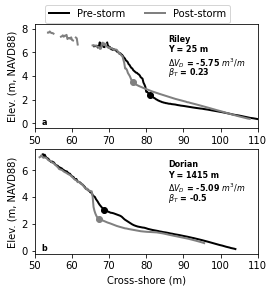

In [13]:
def Figure2():

    '''
    Section creates Figure 2. Section also calculates maximum wave height and maximum reference
    TWL2% for each storm.
    '''
        
    # Get the wave and water level data #
    waves_all = []
    wl_all = []
    twl_all = []
    for yr in np.arange(2013,2022):
        if yr != 2013:
            ws = dataDir+'/FRFWaves/frf_17m_waves.xlsx'
            if yr!=2021:
                hydro = utils.hydroLab(int(str(yr)+'0101'),int(str(yr)+'1231'),station_wl=8651370,station_waves=ws,buoyDepth=17.8)  
            else:
                hydro = utils.hydroLab(int(str(yr)+'0101'),int(str(yr)+'0520'),station_wl=8651370,station_waves=ws,buoyDepth=17.8)              
            waves_all.append(hydro.waves)
            wl_all.append(hydro.wl)
            twl_all.append(hydro.calcTWL(beta=0.1,exceedance=2))
        else:  # Data from 17 m buoy missing for first few months of 2013. Use data from 26 m buoy and transform to 17 m with LWT #
            ws=dataDir+'/FRFWaves/frf_26m_waves.xlsx'
            hydro = utils.hydroLab(int(str(yr)+'0101'),int(str(yr)+'1231'),station_wl=8651370,station_waves=ws,buoyDepth=26)  
            waves = hydro.waves
                       
            for i in range(0,len(waves)):
                dat = waves.iloc[i]
                d = 26
                H = dat['wvht (m)']
                T = dat['Tp (s)']
                theta = dat['MWD (degT)']
                
                if 0<theta<180:               
                    d_vec = np.arange(-d,-16,1) # Vector of water depths #
                    # Wave parameters at buoy #  
                    k0 = utils.newtRaph(T,d)
                    C0 = ((2*np.pi)/k0)/T
                    n0 = 0.5*(1+((2*k0*d)/np.sinh(2*k0*d)))
                    alpha0 = 90-theta
                    Hh = H
                    # Transform #
                    for h in d_vec[1:len(d_vec)]:
                        k = utils.newtRaph(T,-h)
                        C = ((2*np.pi)/k)/T
                        n = 0.5*(1+((2*k*-h)/np.sinh(2*k*-h))) 
                        alpha = np.degrees(math.asin((C/C0)*np.sin(np.radians(alpha0))))
                        Hs = math.sqrt((n0*C0)/(n*C))*math.sqrt(math.cos(math.radians(alpha0))/math.cos(math.radians(alpha)))*Hh
                        
                        k0 = k
                        C0 = C
                        n0 = n
                        alpha0 = alpha
                        Hh = Hs
                        
                    waves.replace({'wvht (m)':waves.iloc[i]['wvht (m)'],'MWD (degT)':waves.iloc[i]['MWD (degT)']},
                                          {'wvht (m)':Hh,'MWD (degT)':360-(270+alpha)},inplace=True)
                else:
                    waves.replace({'wvht (m)':waves.iloc[i]['wvht (m)'],'MWD (degT)':waves.iloc[i]['MWD (degT)']},
                                          {'wvht (m)':np.nan,'MWD (degT)':np.nan},inplace=True)     
                    
            waves_all.append(waves)
            wl_all.append(hydro.wl)
            hydro.waves = waves
            twl_all.append(hydro.calcTWL(beta=0.1,exceedance=2))
                
             
    waves = pd.concat(waves_all,ignore_index=True)
    wl = pd.concat(wl_all,ignore_index=True)
    twl = np.vstack(twl_all)
    
    dtime_waves = [datetime.datetime(int(waves.iloc[i]['yr']),int(waves.iloc[i]['mo']),
                                     int(waves.iloc[i]['day']),int(waves.iloc[i]['hr']),
                                     int(waves.iloc[i]['mm'])) for i in range(0,len(waves))]
    dtime_twl = twl[:,0]
        
    
    # Get the dates of the surveys
    files_use = sorted([i for i in os.listdir(varsDir) if '5km_T' in i])
    dates_all = []
    for file in files_use:       
        bdate = int(file[0:8])
        edate = int(file[9:17])
        dates = (bdate,edate)
        dates_all.append(dates)
    names = ['2013NE','Maria','Riley','Dorian','Humberto','2019NE1','2019NE2','Teddy','2021NE']   
            
    # Make the plot #
    fig,ax = plt.subplots(4,9,figsize=(6.5,4.5))
    twl_max = []
    for i in range(0,len(ax[0])):
        ax[0][i].plot(dtime_waves,np.array(waves['wvht (m)']).astype(float),'.',markersize=1)
        ax[1][i].plot(dtime_waves,np.array(waves['Tp (s)']).astype(float),'.',markersize=1)
        ax[2][i].plot(dtime_waves,np.array(waves['MWD (degT)']).astype(float),'.',markersize=1)
        ax[3][i].plot(dtime_twl,twl[:,1],'.',markersize=1)
        
        bdate = dates_all[i][0]
        edate = dates_all[i][1]
        x1 = datetime.datetime(int(str(bdate)[0:4]),int(str(bdate)[4:6]),int(str(bdate)[6:8]))
        x2 =  datetime.datetime(int(str(edate)[0:4]),int(str(edate)[4:6]),int(str(edate)[6:8]))               
        ax[0][i].set_xlim(x1,x2)
        ax[1][i].set_xlim(x1,x2)
        ax[2][i].set_xlim(x1,x2)
        ax[3][i].set_xlim(x1,x2)
        
        twl_max.append(np.nanmax(twl[:,1][np.logical_and(np.array(dtime_twl)>x1,np.array(dtime_twl)<x2)]))

        ax[0][i].set_ylim(0,6)
        ax[1][i].set_ylim(0,20)
        ax[2][i].set_ylim(0,180);ax[2][i].set_yticks([0,90,180])
        ax[3][i].set_ylim(0,4.5);ax[3][i].set_yticks([0,2,4])
       
        if i!=0:
            ax[0][i].set_yticklabels([])
            ax[1][i].set_yticklabels([])
            ax[2][i].set_yticklabels([])
            ax[3][i].set_yticklabels([])
        else:
            ax[0][i].text(x1-datetime.timedelta(15),ax[0][i].get_ylim()[0]+np.diff(ax[0][i].get_ylim())/2,'$H_s$ (m)',rotation=90,
                          ha='center',va='center')
            ax[1][i].text(x1-datetime.timedelta(15),ax[1][i].get_ylim()[0]+np.diff(ax[1][i].get_ylim())/2,'$T_p$ (s)',rotation=90,
                          ha='center',va='center')
            ax[2][i].text(x1-datetime.timedelta(15),ax[2][i].get_ylim()[0]+np.diff(ax[2][i].get_ylim())/2,'D ($^o$)',rotation=90,
                          ha='center',va='center')
            ax[3][i].text(x1-datetime.timedelta(15),ax[3][i].get_ylim()[0]+np.diff(ax[3][i].get_ylim())/2,'$TWL_{2\%}$ (m)',rotation=90,
                          ha='center',va='center')
            
        
        ax[0][i].set_xticks([x1+((x2-x1)/2)])
        ax[1][i].set_xticks([x1+((x2-x1)/2)])
        ax[2][i].set_xticks([x1+((x2-x1)/2)])
        ax[3][i].set_xticks([x1+((x2-x1)/2)])

        ax[0][i].set_xticklabels([])
        ax[1][i].set_xticklabels([])
        ax[2][i].set_xticklabels([])
        ax[3][i].set_xticklabels([str(int((x2-x1).days))+' days'],rotation=15)
        
        ax[0][i].set_title(names[i],fontweight='normal',rotation=90,fontsize=8)

    print(twl_max)
    plt.subplots_adjust(top=0.86,right=0.964)
    plt.savefig(figsDir+'/Hydrodynamics.png',dpi=400)
    plt.show()

############
############################################


# * #

############################################
# Figure 3 #
############

def Figure3():

    '''
    Section creates Figure 3.
    '''
        
    files = sorted([i for i in os.listdir(varsDir) if '5km_T' in i])
    
    y_locs = [200,1900] # Alongshore location of profile to plot #
    
    cmap = cm.get_cmap('nipy_spectral')
    cols = cmap([0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9])

    
    fig = plt.figure(figsize=(6.5,4))
    ax1 = plt.axes([0.1,0.1,0.4,0.5])
    ax2 = plt.axes([0.55,0.1,0.4,0.5],sharey=ax1)

    hh = []
    iterr=-1
    for file in files:
        iterr+=1
        f = open(varsDir+'/'+file,'rb')
        T = pickle.load(f)
        
        if file==files[0]: # Find the transect to use #
            tt = T[0]
            yy = [ti['Y'][0] for ti in tt]
            iUse1 = int(np.where(np.array(yy)==y_locs[0])[0])
            iUse2 = int(np.where(np.array(yy)==y_locs[1])[0])

        
        hh.append(ax1.plot(T[0][iUse1]['X'],T[0][iUse1]['Z'],color=cols[iterr]))
        hh.append(ax1.plot(T[1][iUse1]['X'],T[1][iUse1]['Z'],'--',color=cols[iterr]))
        ax2.plot(T[0][iUse2]['X'],T[0][iUse2]['Z'],color=cols[iterr])
        ax2.plot(T[1][iUse2]['X'],T[1][iUse2]['Z'],'--',color=cols[iterr])

    hh = [i[0] for i in hh]
    hh = hh[0:len(hh):2]+hh[1:len(hh):2]
    names = ['pre 2013NE','post 2013 NE',
                  'pre Maria','post Maria',
                  'pre Riley','post Riley',
                  'pre Dorian','post Dorian',
                  'pre Humberto','post Humberto',
                  'pre 2019NE1','post 2019NE1',
                  'pre 2019NE2','post 2019NE2',
                  'pre Teddy','post Teddy',
                  'pre 2021NE','post 2021NE']
    names = names[0:len(names):2]+names[1:len(names):2]  
    fig.legend(hh,names,ncol=2,loc='upper center',columnspacing=0.5,handletextpad=0.3,fontsize=8)
    ax1.set_xlabel('Cross-shore (m)')
    ax2.set_xlabel('Cross-shore (m)')
    ax1.set_ylabel('Elev (m, NAVD88)')
    ax2.set_ylabel('')

    ax1.text(0.02, 0.1, 'a (Y = '+str(y_locs[0])+')',ha='left', va='top',transform=ax1.transAxes,fontweight='bold')
    ax2.text(0.02, 0.1, 'b (Y = '+str(y_locs[1])+')',ha='left', va='top',transform=ax2.transAxes,fontweight='bold')

    plt.savefig(figsDir+'/ProfilesThroughTime.png',dpi=400)
    plt.show()

############
############################################


# * #

############################################
# Figure 4 #
############

def Figure4():

    '''
    Section Creates Figure 4. Section also calculate average elevation change at 2 and 4 m contours.
    '''
    
    files = sorted([i for i in os.listdir(varsDir) if '5km_dsms' in i])
  
    fig,ax = plt.subplots(9,1,figsize=(6.5,9))    
    plt.subplots_adjust(top=0.94,bottom=0.1,left=0.1,right=0.95,hspace=0.1)
    cbax = plt.axes([0.325,0.965,0.4,0.007])
    names = ['i (2013NE)','h (Maria)','g (Riley)','f (Dorian)','e (Humberto)','d (2019NE1)','c (2019NE2)','b (Teddy)','a (2021NE)']
    
    for i in range(0,len(files)):        
        f = open(varsDir+'/'+files[i],'rb')
        dsms = pickle.load(f)  
        xx = np.arange(-200,150,0.5)
        yy = np.arange(0,4000,0.5)
        h = ax[-i-1].pcolor(yy,xx,np.transpose(dsms[1]-dsms[0]),vmin=-1,vmax=1,cmap='seismic_r')
        ax[-i-1].contour(yy,xx,np.transpose(dsms[0]),[0.36],colors=['k'],linewidth=0.1)
        ax[-i-1].contour(yy,xx,np.transpose(dsms[0]),[4],colors=['k'],linewidth=0.1)
        ax[-i-1].set_ylim(-80,120)
        ax[-i-1].set_yticks([60,110])
        ax[-i-1].invert_yaxis()
        ax[-i-1].set_xticks([0,1000,2000,3000,4000])
        ax[-i-1].text(50,-20,names[i],fontsize=8,fontweight='bold',ha='left',va='bottom')
        if i!=0:
            ax[-i-1].set_xticklabels([])
            ax[-i-1].set_yticklabels([])
        else:
            ax[-i-1].set_xlabel('Alongshore (m)',fontsize=10)
            ax[-i-1].set_ylabel('Cross-shore (m)',fontsize=10)
            ard = Arrow(3800,60,0,25,width=50,color='k')
            aru = Arrow(3800,60,0,-25,width=50,color='k')
            ax[-i-1].add_patch(ard)
            ax[-i-1].add_artist(aru)            
            ax[-i-1].text(3800,85,'offshore',ha='center',va='top',fontsize=8)
            ax[-i-1].text(3800,35,'onshore',ha='center',va='bottom',fontsize=8)
            arl = Arrow(3200,95,-100,0,width=25,color='k')
            arr = Arrow(3200,95,100,0,width=25,color='k')
            ax[-i-1].add_patch(arl)
            ax[-i-1].add_artist(arr)  
            ax[-i-1].text(3075,100,'south',va='center',ha='right',fontsize=8)
            ax[-i-1].text(3325,100,'north',va='center',ha='left',fontsize=8)
            
        cb = plt.colorbar(h,cbax,orientation='horizontal')
        cb.ax.set_title('$\Delta Z $(m)',fontsize=10)

        # Calculate average elevation changes at z=2 m and z=4 m
        cs2 = plt.contour(yy,xx,np.transpose(dsms[0]),[2],colors=['k'],linewidth=0.1)
        xy2 =cs2.allsegs[0][0]
        difs = []
        for ii in xy2[0:-1:5]:
            d = np.sqrt((np.meshgrid(xx,yy)[0].flatten()-ii[1])**2+(np.meshgrid(xx,yy)[1].flatten()-ii[0])**2)
            d = d[~np.isnan(dsms[0].flatten())]
            iMin = np.where(d==min(d))[0][0]
            z2_pre = float(dsms[0].flatten()[~np.isnan(dsms[0].flatten())][iMin])
            z2_post = float(dsms[1].flatten()[~np.isnan(dsms[0].flatten())][iMin])
            difs.append(round(z2_post-z2_pre,2))
        difsMean2 = np.nanmedian(difs)
        difsStd2 = np.nanstd(difs)

        cs4 = plt.contour(yy,xx,np.transpose(dsms[0]),[4],colors=['k'],linewidth=0.1)
        xy4 =cs4.allsegs[0][0]
        difs = []
        for ii in xy4[0:-1:5]:
            d = np.sqrt((np.meshgrid(xx,yy)[0].flatten()-ii[1])**2+(np.meshgrid(xx,yy)[1].flatten()-ii[0])**2)
            d = d[~np.isnan(dsms[0].flatten())]
            iMin = np.where(d==min(d))[0][0]
            z4_pre = float(dsms[0].flatten()[~np.isnan(dsms[0].flatten())][iMin])
            z4_post = float(dsms[1].flatten()[~np.isnan(dsms[0].flatten())][iMin])
            difs.append(round(z4_post-z4_pre,2))
        difsMean4 = np.nanmedian(difs)
        difsStd4 = np.nanstd(difs)

        print(str(difsMean2)+'p/m '+str(difsStd2),str(difsMean4)+'p/m '+str(difsStd4))
        
    
    plt.savefig(figsDir+'/DoDs.png',dpi=400)
    plt.show()

############
############################################


# * #

############################################
# Figure 5 #
############

def Figure5():

    '''
    Section creates Figure 5. NOTE however, that the three subpanels are created as separate
    figures. These are then combined via Powerpoint or similar to create
    the final figure.
    Code also calculates median values of dune volume change and dune toe retreat trajectory
    for each storm.
    '''
    
    myFmt = mdates.DateFormatter('%Y')

    def createRYBcmap():
        m = 256
        m1=m*0.5
        r = np.arange(0,m1)/(m1-1)
        g = np.arange(0,m1)/(m1-1)
        b = np.arange(0,m1)/(m1-1)
        r = np.vstack([r.reshape(-1,1),np.ones([len(r),1])])
        g = np.vstack([g.reshape(-1,1),np.flipud(g.reshape(-1,1))])
        b = np.vstack([b.reshape(-1,1),np.ones([len(b),1])])
        b = np.flipud(b)
        b = np.flipud(np.linspace(0,1,len(r))).reshape(-1,1)
        
        c = np.hstack([r,g,b,np.ones([len(r),1])])
        return np.flipud(c)
        
    c = createRYBcmap()
    ryb = ListedColormap(c)
       
    files_use = sorted([i for i in os.listdir(varsDir) if 'DuneRetreatResults' in i])
    results_byStorm = pd.DataFrame(columns=['Name','results'])
    for file in files_use:
        
        results = pd.DataFrame(columns=['Y','BT','dx (m)','$\Delta V_D$ ($m^3/m$)'])
        bdate = int(file[0:8])
        edate = int(file[9:17])
     
        f = open(varsDir+'/'+file,'rb')
        scarpResults=pickle.load(f)
        Bf = scarpResults.Bf
        BT = scarpResults.BT
        scarpToes = scarpResults.scarpToes
        T_scarps = scarpResults.T_scarps
        forwardFlag = scarpResults.forwardFlag
        
        for scarp in range(0,len(T_scarps)):
            for ii in range(0,len(T_scarps[scarp][0])):
                
                if ii not in forwardFlag[scarp]:
                
                    BT_here = BT[scarp][ii]
                    
                    y_here = T_scarps[scarp][0][ii]['Y'][0]
                                      
                    # Calc toe dx #
                    dx = scarpToes[scarp][1][ii][0] - scarpToes[scarp][0][ii][0]
                               
                    # Calc pre- and post-storm volume (dune) #
                    x_end = scarpToes[scarp][0][ii][0]
                    x_start = max((min(T_scarps[scarp][0][ii]['X']),min(T_scarps[scarp][1][ii]['X'])))
                    vol_dune1 = []
                    for d in range(0,2):
                        i1 = np.logical_and(T_scarps[scarp][d][ii]['X']>=x_start,T_scarps[scarp][d][ii]['X']<=x_end)
                        xx = T_scarps[scarp][d][ii]['X'][i1]
                        zz = T_scarps[scarp][d][ii]['Z'][i1]
                        vol = np.trapz(zz[~np.isnan(zz)],xx[~np.isnan(zz)])
                        vol_dune1.append(vol)
                    vol_dune = vol_dune1[1]-vol_dune1[0]
                                     
             
                    results = results.append({'Y':y_here,
                                              'BT':BT_here,                                             
                                              'dx (m)':dx,                                              
                                              '$\Delta V_D$ ($m^3/m$)':vol_dune},
                                             ignore_index=True)      
                
        if len(results)>0:
        
            if bdate==20130306:
                name = '2013NE'
            elif bdate==20180303:
                name = 'Riley'
            elif bdate==20190904:
                name = 'Dorian'
            elif bdate==20191011:
                name = '2019NE1'
            elif bdate==20191114:
                name = '2019NE2'
            elif bdate==20200910:
                name = 'Teddy'
            elif bdate==20210318:
                name = '2021NE'
            else:
                name = 'WHAT?'
            
            results_byStorm = results_byStorm.append({'Name':name,'results':results},ignore_index=True)    
    
  
    
    names = ['2013NE','Riley','Dorian','2019NE1','2019NE2','Teddy','2021NE']
    yy = np.array([datetime.datetime(2011,1,1)+datetime.timedelta(days=i) for i in range(0,(365*11)+20,100)])
    xx = np.arange(-1000,4100,100)

    def plotVdPanel():
    
        # Plot the storms #
        fig = plt.figure(figsize=(3.25,6))
        plt.rcParams.update({'font.size': 8})
        ax1 = plt.axes([0.15,0.08,0.72,0.25])
        ax1.set_xlim(0,4000)
        ax1.set_ylim(datetime.datetime(2013,1,1),datetime.datetime(2014,12,31))
        ax1.spines['top'].set_visible(False)
        ax1.set_yticks([datetime.datetime(2013,1,1),datetime.datetime(2014,1,1)])
        ax1.yaxis.set_major_formatter(myFmt)
        ax2 = plt.axes([0.15,0.33,0.72,0.62])
        ax2.set_xlim(0,4000)
        ax2.set_ylim(datetime.datetime(2017,1,1),datetime.datetime(2021,12,13)) 
        ax2.spines['bottom'].set_visible(False)
        ax2.set_xticks([])
        ax2.set_yticks([datetime.datetime(2017,1,1),datetime.datetime(2018,1,1),datetime.datetime(2019,1,1),datetime.datetime(2020,1,1),datetime.datetime(2021,1,1)])
        ax2.yaxis.set_major_formatter(myFmt)
    
    
        d = .015  # how big to make the diagonal lines in axes coordinates
        kwargs = dict(transform=ax1.transAxes, color='k', clip_on=False)
        ax1.plot((-d, +d), (.7-d, .7+d), **kwargs)        # top-left diagonal
        ax1.plot((1 - d, 1 + d), (.7-d, .7+d), **kwargs)  # top-right diagonal

        kwargs.update(transform=ax2.transAxes)  # switch to the bottom axes
        ax2.plot((-d, +d), (-.09-d, -.11+d), **kwargs)  # bottom-left diagonal
        ax2.plot((1 - d, 1 + d), (-.09-d, -.11+d), **kwargs)  # bottom-right diagonal

    
        for ax in [ax1,ax2]:
            dates_storms = [datetime.datetime(2013,3,13),datetime.datetime(2017,9,25),
                            datetime.datetime(2018,3,6),datetime.datetime(2019,9,7),
                            datetime.datetime(2019,9,17),datetime.datetime(2019,10,12),
                            datetime.datetime(2019,11,16),
                            datetime.datetime(2020,9,17,12),datetime.datetime(2021,3,20,12)]
            for i in range(0,len(dates_storms)):
                ax.plot((min(xx),max(xx)),(dates_storms[i],dates_storms[i]),'k--',linewidth=0.5)
                
            
        dates_storms_use = [datetime.datetime(2013,3,13),
                            datetime.datetime(2018,3,6),datetime.datetime(2019,9,7),
                            datetime.datetime(2019,10,12),
                            datetime.datetime(2019,11,16),
                            datetime.datetime(2020,9,17,12),datetime.datetime(2021,3,20,12)]
    
        for i in range(0,len(dates_storms_use)):
            date_plot = dates_storms_use[i]
            
            # Move 2019 data to help visualization #
            if i==2:
                date_plot = date_plot-datetime.timedelta(days=40)
            elif i==4:
                date_plot = date_plot+datetime.timedelta(days=40)
                
            locs = np.array(results_byStorm.loc[i]['results']['Y'])
            vals = np.array(results_byStorm.loc[i]['results']['$\Delta V_D$ ($m^3/m$)'])
            times = np.tile(date_plot,len(locs))
                
            for ax in [ax1,ax2]:
                a = ax.scatter(locs,times,200,vals,marker='|',cmap='copper',vmin=-15,vmax=0,alpha=1)


        cbax = plt.axes([0.35,0.3,0.3,0.01])
        cbax.set_xticks([])
        cbax.set_yticks([])
        plt.colorbar(a,cbax,orientation='horizontal',label='$\Delta V_D$ ($m^3/m$)',ticks=[-15,-10,-5,0])   
        
        ax2.text(0.02,0.97,'a',transform=ax2.transAxes,fontweight='bold')
        plt.savefig(figsDir+'/DuneChangeSummary_1',dpi=450)

    def plotBTPanel():
    
        # Plot the storms with labels #
        fig = plt.figure(figsize=(3.25,6))
        plt.rcParams.update({'font.size': 8})
        ax1 = plt.axes([0.08,0.08,0.72,0.25])#plt.axes([0.15,0.08,0.72,0.25])
        ax1.set_xlim(0,4000)
        ax1.set_ylim(datetime.datetime(2013,1,1),datetime.datetime(2014,12,31))
        ax1.spines['top'].set_visible(False)
        ax1.set_yticks([datetime.datetime(2013,1,1),datetime.datetime(2014,1,1)])
        ax1.yaxis.set_major_formatter(myFmt)
        ax2 = plt.axes([0.08,0.33,0.72,0.62])#plt.axes([0.15,0.33,0.72,0.62])
        ax2.set_xlim(0,4000)
        ax2.set_ylim(datetime.datetime(2017,1,1),datetime.datetime(2021,12,13)) 
        ax2.spines['bottom'].set_visible(False)
        ax2.set_xticks([])
        ax2.set_yticks([datetime.datetime(2017,1,1),datetime.datetime(2018,1,1),datetime.datetime(2019,1,1),datetime.datetime(2020,1,1),datetime.datetime(2021,1,1)])
        ax2.yaxis.set_major_formatter(myFmt)
    
    
        d = .015  # how big to make the diagonal lines in axes coordinates
        kwargs = dict(transform=ax1.transAxes, color='k', clip_on=False)
        ax1.plot((-d, +d), (.7-d, .7+d), **kwargs)        # top-left diagonal
        ax1.plot((1 - d, 1 + d), (.7-d, .7+d), **kwargs)  # top-right diagonal

        kwargs.update(transform=ax2.transAxes)  # switch to the bottom axes
        ax2.plot((-d, +d), (-.09-d, -.11+d), **kwargs)  # bottom-left diagonal
        ax2.plot((1 - d, 1 + d), (-.09-d, -.11+d), **kwargs)  # bottom-right diagonal

    
        for ax in [ax1,ax2]:
            dates_storms = [datetime.datetime(2013,3,13),datetime.datetime(2017,9,25),
                            datetime.datetime(2018,3,6),datetime.datetime(2019,9,7),
                            datetime.datetime(2019,9,17),datetime.datetime(2019,10,12),
                            datetime.datetime(2019,11,16),
                            datetime.datetime(2020,9,17,12),datetime.datetime(2021,3,20,12)]
            for i in range(0,len(dates_storms)):
                ax.plot((min(xx),max(xx)),(dates_storms[i],dates_storms[i]),'k--',linewidth=0.5)
                
        ax1.text(4025,dates_storms[0],'NorEaster',va='center',ha='left',fontweight='bold',fontsize=8)
        ax2.text(4025,dates_storms[1],'Maria',va='center',fontsize=8)
        ax2.text(4025,dates_storms[2],'Riley',va='center',ha='left',fontweight='bold',fontsize=8)
        ax2.text(4025,dates_storms[3]-datetime.timedelta(days=50),'Dorian',va='center',ha='left',fontweight='bold',fontsize=8)
        ax2.text(4025,dates_storms[4]-datetime.timedelta(days=20),'Humberto',va='center',ha='left',fontsize=8)
        ax2.text(4025,dates_storms[5]+datetime.timedelta(days=5),'NorEaster',va='center',ha='left',fontweight='bold',fontsize=8)
        ax2.text(4025,dates_storms[6]+datetime.timedelta(days=15),'NorEaster',va='center',ha='left',fontweight='bold',fontsize=8)
        ax2.text(4025,dates_storms[7],'Teddy',va='center',ha='left',fontweight='bold',fontsize=8)
        ax2.text(4025,dates_storms[8],'NorEaster',va='center',ha='left',fontweight='bold',fontsize=8)
        ax1.set_xlabel('Alongshore (m)')
            
        dates_storms_use = [datetime.datetime(2013,3,13),
                            datetime.datetime(2018,3,6),datetime.datetime(2019,9,7),
                            datetime.datetime(2019,10,12),
                            datetime.datetime(2019,11,16),
                            datetime.datetime(2020,9,17,12),datetime.datetime(2021,3,20,12)]
    
        for i in range(0,len(dates_storms_use)):
            date_plot = dates_storms_use[i]
            
            # Move 2019 data to help visualization #
            if i==2:
                date_plot = date_plot-datetime.timedelta(days=40)
            elif i==4:
                date_plot = date_plot+datetime.timedelta(days=40)
                
            locs = np.array(results_byStorm.loc[i]['results']['Y'])
            vals = np.array(results_byStorm.loc[i]['results']['BT'])
            times = np.tile(date_plot,len(locs))
                
            for ax in [ax1,ax2]:
                a = ax.scatter(locs,times,200,vals,marker='|',cmap=ryb,vmin=-0.2,vmax=0.2,alpha=1)


        cbax = plt.axes([0.30,0.3,0.3,0.01])#plt.axes([0.35,0.3,0.3,0.01])
        cbax.set_xticks([])
        cbax.set_yticks([])
        plt.colorbar(a,cbax,orientation='horizontal',label=r'$ \beta_T $',ticks=[-0.2,0,0.2])   
        
        ax2.text(0.02,0.97,'b',transform=ax2.transAxes,fontweight='bold')
        ax2.set_yticklabels([])
        ax1.set_yticklabels([])
        plt.savefig(figsDir+'/DuneChangeSummary_2',dpi=450)


    def plotBoxplotsPanel():

        V = []
        BT = []
        for ii in range(0,len(results_byStorm)):
            name = results_byStorm.loc[ii]['Name']
            V.append(results_byStorm.loc[ii]['results']['$\Delta V_D$ ($m^3/m$)'])
            BT.append(results_byStorm.loc[ii]['results']['BT'])
        print([np.median(i) for i in V])
        print([np.median(i) for i in BT])

        fig,ax = plt.subplots(2,1,figsize=(6,2),sharex=True)
        ax[0].boxplot(V,showfliers=False,labels=names)
        ax[1].boxplot(BT,showfliers=False,labels=names)
        ax[0].set_ylabel('$\Delta V_D$ ($m^3/m$)')
        ax[1].set_ylabel(r'$ \beta_T $')
        ax[1].set_ylim(-0.9,0.7)
        fig.align_ylabels()
        ax[0].text(0.005,0.85,'c',transform=ax[0].transAxes,fontweight='bold')
        ax[1].text(0.005,0.85,'d',transform=ax[1].transAxes,fontweight='bold')
        plt.savefig(figsDir+'/DuneChangeSummary_3',dpi=450)

    plotVdPanel()
    plotBTPanel()
    plotBoxplotsPanel()
    plt.show()

############
############################################


# * #

############################################
# Figure 6 #
############

def Figure6():

    '''
    Section creates Figure 6.
    '''
    
    files_use = sorted([i for i in os.listdir(varsDir) if '5km_T' in i])
    print(files_use)
    results = pd.DataFrame(columns=['Name','$Z_{toe}$ (m)','$TWL_{max}$ (m)','max F (m)'])
    for file in files_use:
        
        bdate = int(file[0:8])
        edate = int(file[9:17])
        if '2013'  not in str(bdate):
            ws = dataDir+'/FRFWaves/frf_17m_waves.xlsx'
            hydro = utils.hydroLab(bdate,edate,station_wl=8651370,station_waves=ws,buoyDepth=17.8)  
        else:  # Data from 17 m buoy missing for first few months of 2013. Use data from 26 m buoy and transform to 17 m with LWT #
            ws = dataDir+'/FRFWaves/frf_26m_waves.xlsx'
            hydro = utils.hydroLab(bdate,edate,station_wl=8651370,station_waves=ws,buoyDepth=26)  
            waves = hydro.waves                      
            for i in range(0,len(waves)):
                dat = waves.iloc[i]
                d = 26
                H = dat['wvht (m)']
                T = dat['Tp (s)']
                theta = dat['MWD (degT)']
                
                if 0<theta<180:               
                    d_vec = np.arange(-d,-16,1) # Vector of water depths #
                    # Wave parameters at buoy #  
                    k0 = utils.newtRaph(T,d)
                    C0 = ((2*np.pi)/k0)/T
                    n0 = 0.5*(1+((2*k0*d)/np.sinh(2*k0*d)))
                    alpha0 = 90-theta
                    Hh = H
                    # Transform #
                    for h in d_vec[1:len(d_vec)]:
                        k = utils.newtRaph(T,-h)
                        C = ((2*np.pi)/k)/T
                        n = 0.5*(1+((2*k*-h)/np.sinh(2*k*-h))) 
                        alpha = np.degrees(math.asin((C/C0)*np.sin(np.radians(alpha0))))
                        Hs = math.sqrt((n0*C0)/(n*C))*math.sqrt(math.cos(math.radians(alpha0))/math.cos(math.radians(alpha)))*Hh
                        
                        k0 = k
                        C0 = C
                        n0 = n
                        alpha0 = alpha
                        Hh = Hs
                        
                    waves.replace({'wvht (m)':waves.iloc[i]['wvht (m)'],'MWD (degT)':waves.iloc[i]['MWD (degT)']},
                                          {'wvht (m)':Hh,'MWD (degT)':360-(270+alpha)},inplace=True)
                else:
                    waves.replace({'wvht (m)':waves.iloc[i]['wvht (m)'],'MWD (degT)':waves.iloc[i]['MWD (degT)']},
                                          {'wvht (m)':np.nan,'MWD (degT)':np.nan},inplace=True)     
                    
            hydro.waves = waves
            
        f = open(varsDir+'/'+file,'rb')
        T = pickle.load(f)
        print(file)
        print(len(T[1]))
        
        # Calculate TWL and F using slope and toe at every transect #
        mgr = claris.scarpManager()
        toes = mgr.idDuneToe(T, method='mc_supervised')
        Bf = []
        for ii in range(0,len(toes[0])):

            x_beta = T[0][ii]['X'][np.logical_and(T[0][ii]['X']>=toes[0][ii,0],T[0][ii]['Z']>=0.36)]
            z_beta = T[0][ii]['Z'][np.logical_and(T[0][ii]['X']>=toes[0][ii,0],T[0][ii]['Z']>=0.36)]
            try:
                b,yhat,r2,p_values = utils.linearRegression(x_beta[~np.isnan(z_beta)],z_beta[~np.isnan(z_beta)])
                m=b[1]
            except:
                m = np.nan
            Bf.append(-m)
        
        twl = []
        F =[]
        for Bf_here,toe_here in zip(Bf,toes[0]):
            if not np.isnan(Bf_here):
                twl1 = hydro.calcTWL(Bf_here,exceedance=2)
                F1 = max(twl1[:,1])-toe_here[2]
                twl.append(max(twl1[:,1]))
                F.append(F1)
            else:
                twl.append(np.nan)
                F.append(np.nan)
                
        # Get the name #                       
        if bdate==20130306:
            name = '2013NE'
        elif bdate==20170922:
            name = 'Maria'
        elif bdate==20180303:
            name = 'Riley'
        elif bdate==20190904:
            name = 'Dorian'
        elif bdate==20190910:
            name = 'Humberto'
        elif bdate==20191011:
            name = '2019NE1'
        elif bdate==20191114:
            name = '2019NE2'
        elif bdate==20200305:
            name = '2020NE'
        elif bdate==20200910:
            name = 'Teddy'
        elif bdate==20210318:
            name = '2021NE'
            
        results = results.append({'Name':name,
                       '$Z_{toe}$ (m)':toes[0][:,2],
                       '$TWL_{max}$ (m)':twl,
                       'max F (m)':F},
                       ignore_index=True)
                 
      
    def runAvg(x,y,window=10):
        xx = x[0]
        x_smooth=[]
        y_smooth=[]
        while xx in x:
            x_start = xx
            x_end = xx+window
            x_window = x[np.logical_and(x>=x_start,x<=x_end)]
            y_window = y[np.logical_and(x>=x_start,x<=x_end)]
            x_smooth.append(np.nanmean(x_window))
            y_smooth.append(np.nanmean(y_window))
            xx=x_end   
        return np.array(x_smooth),np.array(y_smooth)    
    
    # Make the figure #
    names = ['2013NE','Maria','Riley','Dorian','Humberto','2019NE1','2019NE2','Teddy','2021NE']
    labs = ['i','h','g','f','e','d','c','b','a']
    fig,ax = plt.subplots(9,1,figsize=(5,6))
    method = 'mc'
    files_use = sorted([i for i in os.listdir(varsDir) if '5km_T' in i])
    for i in range(0,len(files_use)):        
        
        storm = names[i]
        xx,ztoe = runAvg(np.arange(0,4000,5),results['$Z_{toe}$ (m)'][np.where(results['Name']==storm)[0][0]],window=50)
        xx,twl = runAvg(np.arange(0,4000,5),np.array(results['$TWL_{max}$ (m)'][np.where(results['Name']==storm)[0][0]]),window=50)
        h1 = ax[-i-1].plot(xx,ztoe,'k')
        h2 = ax[-i-1].plot(xx,twl,'b')
        ax[-i-1].set_ylim(1.5,5.5)
        
        try:
            f = open(varsDir+'/'+files_use[i][0:17]+'_5km_DuneRetreatResults.pkl','rb')
        except Exception as e:
            yl = ax[-i-1].get_ylim()
            print(e)
        else:
            scarpResults=pickle.load(f)
            T_scarps = scarpResults.T_scarps
            yl = ax[-i-1].get_ylim()
            difs_all = []
            for ii in range(0,len(T_scarps)):
                y_start = T_scarps[ii][0][0]['Y'][0]
                y_end = T_scarps[ii][0][-1]['Y'][0]
                iUse = np.where(np.logical_and(xx>y_start,xx<y_end))
                difs = (twl[iUse]-ztoe[iUse])/ztoe[iUse]
                difs_all.append(difs)
                r = Rectangle((y_start,yl[0]),y_end-y_start,np.diff(yl),facecolor='grey')
                ax[-i-1].add_artist(r)
        ax[-i-1].set_ylim(yl)
        ax[-i-1].set_xlim(0,4000)
        ax[-i-1].set_xticks([0,1000,2000,3000,4000])
        ax[-i-1].text(4050,3.5,labs[i]+' ('+names[i]+')',va='center',ha='left',fontsize=8,fontweight='bold')
        if -i-1 != -1:
            ax[-i-1].set_xticklabels([])
        ax[-1].set_xlabel('Alongshore (m)')
        ax[4].set_ylabel('Elev (m)')
        fig.legend([h1[0],h2[0]],['$Z_{toe}$','$TWL_{2\%}$'],loc='upper center',ncol=2,frameon=False)

    plt.subplots_adjust(left=0.125,bottom=0.067,right=0.812,top=0.955,wspace=0.2,hspace=0.2)
    plt.savefig(figsDir+'/TWLVsZToeVsRetreat',dpi=450)
    plt.show() 

############
############################################


# * #

############################################
# Figures 7, 8, and 10 #
############

def Figure7_8_10():

    '''
    Section creates Figures 7, 8, and 10.

    NOTE for Figure 7: The two subpanels are created as separate figures. These
                       are later combined in Powerpoint or similar to create the final figure.
    NOTE for Figure 8: None
    NOTE for Figure 10: Section also prints R^2 value of the exponential fit.
    '''
    
    method = 'mc'
    files_use = sorted([i for i in os.listdir(varsDir) if 'DuneRetreatResults' in i])
    results_byStorm = pd.DataFrame(columns=['Name','results'])
    c=-1
    for file in files_use:
        
        results = pd.DataFrame(columns=['BT',
                                        '$TWL_{R2%}$','$TWL_{R7%}$','$TWL_{R16%}$','$TWL_{R50%}$',
                                        '$F_{R2%}$','$F_{R7%}$','$F_{R16%}$','$F_{R50%}$',
                                        '$ti_{R2%}$','$ti_{R7%}$','$ti_{R16%}$','$ti_{R50%}$'])
        bdate = int(file[0:8])
        edate = int(file[9:17])
        
        if '2013'  not in str(bdate):
            ws = dataDir+'/FRFWaves/frf_17m_waves.xlsx'
            hydro = utils.hydroLab(bdate,edate,station_wl=8651370,station_waves=ws,buoyDepth=17.8)  
        else:  # Data from 17 m buoy missing for first few months of 2013. Use data from 26 m buoy and transform to 17 m with LWT #
            ws = dataDir+'/FRFWaves/frf_26m_waves.xlsx'
            hydro = utils.hydroLab(bdate,edate,station_wl=8651370,station_waves=ws,buoyDepth=26)  
            waves = hydro.waves                      
            for i in range(0,len(waves)):
                dat = waves.iloc[i]
                d = 26
                H = dat['wvht (m)']
                T = dat['Tp (s)']
                theta = dat['MWD (degT)']
                
                if 0<theta<180:               
                    d_vec = np.arange(-d,-16,1) # Vector of water depths #
                    # Wave parameters at buoy #  
                    k0 = utils.newtRaph(T,d)
                    C0 = ((2*np.pi)/k0)/T
                    n0 = 0.5*(1+((2*k0*d)/np.sinh(2*k0*d)))
                    alpha0 = 90-theta
                    Hh = H
                    # Transform #
                    for h in d_vec[1:len(d_vec)]:
                        k = utils.newtRaph(T,-h)
                        C = ((2*np.pi)/k)/T
                        n = 0.5*(1+((2*k*-h)/np.sinh(2*k*-h))) 
                        alpha = np.degrees(math.asin((C/C0)*np.sin(np.radians(alpha0))))
                        Hs = math.sqrt((n0*C0)/(n*C))*math.sqrt(math.cos(math.radians(alpha0))/math.cos(math.radians(alpha)))*Hh
                        
                        k0 = k
                        C0 = C
                        n0 = n
                        alpha0 = alpha
                        Hh = Hs
                        
                    waves.replace({'wvht (m)':waves.iloc[i]['wvht (m)'],'MWD (degT)':waves.iloc[i]['MWD (degT)']},
                                          {'wvht (m)':Hh,'MWD (degT)':360-(270+alpha)},inplace=True)
                else:
                    waves.replace({'wvht (m)':waves.iloc[i]['wvht (m)'],'MWD (degT)':waves.iloc[i]['MWD (degT)']},
                                          {'wvht (m)':np.nan,'MWD (degT)':np.nan},inplace=True)     
                    
            hydro.waves = waves
        

        f = open(varsDir+'/'+file,'rb')
        scarpResults=pickle.load(f)
        Bf = scarpResults.Bf
        BT = scarpResults.BT
        scarpToes = scarpResults.scarpToes
        T_scarps = scarpResults.T_scarps
        forwardFlag = scarpResults.forwardFlag

        
        for scarp in range(0,len(T_scarps)):
            for ii in range(0,len(T_scarps[scarp][0])):
                
                if ii not in forwardFlag[scarp]:
                                
                    BT_here = BT[scarp][ii]
                    Bf_here = Bf[scarp][ii]
                    toe_pre = scarpToes[scarp][0][ii][2]
                    
                    F_all = []
                    ti_all = []
                    twl_all = []
                    for exc in [2,7,16,50]:
                        # Calc TWL freeboard #
                        twl = hydro.calcTWL(Bf_here,exceedance=exc)
                        F = max(twl[:,1])-toe_pre
                        F_all.append(F)
                        twl_all.append(max(twl[:,1]))
                        
    
                        # Calc impact duration #
                        impact_dur_i = np.where(twl[:,1]>scarpToes[scarp][0][ii][2])[0]
                        if len(impact_dur_i)==0:
                            impact_dur=0
                        elif len(impact_dur_i)==1:
                            impact_dur=0.5
                        else:
                            impact_dur = (len(impact_dur_i)-1)/2 # Assuming sampling is half hour #
                        ti_all.append(impact_dur)
                
                    results = results.append({'BT':BT_here,
                                              '$TWL_{R2%}$':twl_all[0],
                                              '$TWL_{R7%}$':twl_all[1],
                                              '$TWL_{R16%}$':twl_all[2],
                                              '$TWL_{R50%}$':twl_all[3],
                                              '$F_{R2%}$':F_all[0],
                                              '$F_{R7%}$':F_all[1],
                                              '$F_{R16%}$':F_all[2],
                                              '$F_{R50%}$':F_all[3],
                                              '$ti_{R2%}$':ti_all[0],
                                              '$ti_{R7%}$':ti_all[1],
                                              '$ti_{R16%}$':ti_all[2],
                                              '$ti_{R50%}$':ti_all[3]
                                              },
                                             ignore_index=True)      
                
        if bdate==20130306:
            name = '2013NE'
        elif bdate==20180303:
            name = 'Riley'
        elif bdate==20190904:
            name = 'Dorian'
        elif bdate==20191011:
            name = '2019NE1'
        elif bdate==20191114:
            name = '2019NE2'
        elif bdate==20200910:
            name = 'Teddy'
        elif bdate==20210318:
            name = '2021NE'
            
        results_byStorm = results_byStorm.append({'Name':name,'results':results},ignore_index=True)

    names = ['2013NE','Maria','Riley','Dorian','Humberto','2019NE1','2019NE2','Teddy','2021NE']

    # Get all and storm-averaged values #        
    BT_mean = []
    F_mean = []
    ti_mean = []
    BT_all = []
    F_all = []
    ti_all = []
    for exc in [2,7,16]:
    
        BT_mean1 = []
        F_mean1 = []
        ti_mean1 = []
        BT_all1 = []
        F_all1 = []
        ti_all1 = []
        for ii in range(0,len(results_byStorm)):
            name = results_byStorm.loc[ii]['Name']
            results = results_byStorm.loc[ii]['results']
            if len(results)>0:
                BT = np.nanmedian(np.array(results['BT']))
                BT_25 = np.nanpercentile(np.array(results['BT']),25)
                BT_75 = np.nanpercentile(np.array(results['BT']),75)
                F = np.nanmedian(np.array(results['$F_{R'+str(exc)+'%}$']))
                F_25 = np.nanpercentile(np.array(results['$F_{R'+str(exc)+'%}$']),25)
                F_75 = np.nanpercentile(np.array(results['$F_{R'+str(exc)+'%}$']),75)
                ti = np.nanmedian(np.array(results['$ti_{R'+str(exc)+'%}$']))
                ti_25 = np.nanpercentile(np.array(results['$ti_{R'+str(exc)+'%}$']),25)
                ti_75 = np.nanpercentile(np.array(results['$ti_{R'+str(exc)+'%}$']),75) 
                
                BT_mean1.append([BT,(BT_25,BT_75)])
                F_mean1.append([F,(F_25,F_75)])
                ti_mean1.append([ti,(ti_25,ti_75)])
                
                BT_all1.append(np.array(results['BT']))
                F_all1.append(np.array(results['$F_{R'+str(exc)+'%}$']))
                ti_all1.append(np.array(results['$ti_{R'+str(exc)+'%}$']))
        
        BT_mean = BT_mean1
        F_mean.append(F_mean1)
        ti_mean.append(ti_mean1)
        BT_all.append(BT_all1)
        F_all.append(F_all1)
        ti_all.append(ti_all1)


    ################
    # Figure 7 #
    ################
    def makeFTPanel():
        
        fig,ax = plt.subplots(3,2,figsize=(3.25,6))
        excs=[2,7,16]
        for i in range(0,len(excs)):
            [ax[i][0].plot(F_all[i][ii],BT_all[i][ii],'.',markersize=2) for ii in range(0,len(BT_all[0]))]
            hh = []
            for ii in range(0,len(F_mean[i])):
                ax[i][1].plot((F_mean[i][ii][0],F_mean[i][ii][0]),(BT_mean[ii][0],BT_mean[ii][1][0]),'k',linewidth=1)
                ax[i][1].plot((F_mean[i][ii][0],F_mean[i][ii][0]),(BT_mean[ii][0],BT_mean[ii][1][1]),'k',linewidth=1)
                ax[i][1].plot((F_mean[i][ii][0],F_mean[i][ii][1][0]),(BT_mean[ii][0],BT_mean[ii][0]),'k',linewidth=1)
                ax[i][1].plot((F_mean[i][ii][0],F_mean[i][ii][1][1]),(BT_mean[ii][0],BT_mean[ii][0]),'k',linewidth=1)
                hh.append(ax[i][1].plot(F_mean[i][ii][0],BT_mean[ii][0],'s',alpha=0.8,markersize=14))

            ax[i,0].set_ylabel(r'$ \beta_T $')
            fig.legend([ii[0] for ii in hh],['2013NE','Riley','Dorian','2019NE1','2019NE2','Teddy','2021NE'],loc='upper center',
                   frameon=True,handletextpad=0.1,fontsize=8,ncol=2,markerscale=0.5)
            ax[0,0].set_xlabel(r'$F_{T,2\%}$ (m)')
            ax[0,1].set_xlabel(r'$F_{T,2\%}$ (m)')
            ax[1,0].set_xlabel(r'$F_{T,7\%}$ (m)')
            ax[1,1].set_xlabel(r'$F_{T,7\%}$ (m)')        
            ax[2,0].set_xlabel(r'$F_{T,16\%}$ (m)')
            ax[2,1].set_xlabel(r'$F_{T,16\%}$ (m)')
            ax[0,0].text(0.01,0.9,'a',fontsize=8,fontweight='bold',transform=ax[0][0].transAxes)
            ax[0,1].text(0.01,0.9,'b',fontsize=8,fontweight='bold',transform=ax[0][1].transAxes)
            ax[1,0].text(0.01,0.9,'c',fontsize=8,fontweight='bold',transform=ax[1][0].transAxes)
            ax[1,1].text(0.01,0.9,'d',fontsize=8,fontweight='bold',transform=ax[1][1].transAxes)            
            ax[2,0].text(0.01,0.9,'e',fontsize=8,fontweight='bold',transform=ax[2][0].transAxes)
            ax[2,1].text(0.01,0.9,'f',fontsize=8,fontweight='bold',transform=ax[2][1].transAxes)

            plt.subplots_adjust(left=0.2, bottom=0.11, right=0.95, top=0.87, wspace=0.414, hspace=0.42)
            plt.savefig(figsDir+'/BTvsFTandImpactDur_Rm_1.png',dpi=450)

    def makeTIPanel():
        
        fig,ax = plt.subplots(3,2,figsize=(3.25,6))
        excs=[2,7,16]
        for i in range(0,len(excs)):
            [ax[i][0].plot(ti_all[i][ii],BT_all[i][ii],'.',markersize=2) for ii in range(0,len(BT_all[0]))]
            hh = []
            for ii in range(0,len(F_mean[i])):
                ax[i][1].plot((ti_mean[i][ii][0],ti_mean[i][ii][0]),(BT_mean[ii][0],BT_mean[ii][1][0]),'k',linewidth=1)
                ax[i][1].plot((ti_mean[i][ii][0],ti_mean[i][ii][0]),(BT_mean[ii][0],BT_mean[ii][1][1]),'k',linewidth=1)
                ax[i][1].plot((ti_mean[i][ii][0],ti_mean[i][ii][1][0]),(BT_mean[ii][0],BT_mean[ii][0]),'k',linewidth=1)
                ax[i][1].plot((ti_mean[i][ii][0],ti_mean[i][ii][1][1]),(BT_mean[ii][0],BT_mean[ii][0]),'k',linewidth=1)
                hh.append(ax[i][1].plot(ti_mean[i][ii][0],BT_mean[ii][0],'s',alpha=0.8,markersize=14))

            ax[i,0].set_ylabel(r'$ \beta_T $')
            fig.legend([ii[0] for ii in hh],['2013NE','Riley','Dorian','2019NE1','2019NE2','Teddy','2021NE'],loc='upper center',
                   frameon=True,handletextpad=0.1,fontsize=8,ncol=2,markerscale=0.5)
            ax[0,0].set_xlabel(r'$t_{I,2\%}$ (hr)')
            ax[0,1].set_xlabel(r'$t_{I,2\%}$ (hr)')
            ax[1,0].set_xlabel(r'$t_{I,7\%}$ (hr)')
            ax[1,1].set_xlabel(r'$t_{I,7\%}$ (hr)')        
            ax[2,0].set_xlabel(r'$t_{I,16\%}$ (hr)')
            ax[2,1].set_xlabel(r'$t_{I,16\%}$ (hr)')
            ax[0,0].text(0.01,0.9,'g',fontsize=8,fontweight='bold',transform=ax[0][0].transAxes)
            ax[0,1].text(0.01,0.9,'h',fontsize=8,fontweight='bold',transform=ax[0][1].transAxes)
            ax[1,0].text(0.01,0.9,'i',fontsize=8,fontweight='bold',transform=ax[1][0].transAxes)
            ax[1,1].text(0.01,0.9,'j',fontsize=8,fontweight='bold',transform=ax[1][1].transAxes)            
            ax[2,0].text(0.01,0.9,'k',fontsize=8,fontweight='bold',transform=ax[2][0].transAxes)
            ax[2,1].text(0.01,0.9,'l',fontsize=8,fontweight='bold',transform=ax[2][1].transAxes)

            plt.subplots_adjust(left=0.2, bottom=0.11, right=0.95, top=0.87, wspace=0.414, hspace=0.42)
            plt.savefig(figsDir+'/BTvsFTandImpactDur_Rm_2.png',dpi=450)

    
    makeFTPanel()
    makeTIPanel()


    ################
    # Figure 8 #
    ################    
    fig,ax = plt.subplots(1,figsize=(3.5,3))
    h = []
    for ii in range(0,len(F_all[0])):
        hh = ax.plot(F_all[0][ii],ti_all[0][ii],'.',markersize=4)
        h.append(hh[0])
    ax.legend(h,names,loc='upper left',frameon=True,handletextpad=0.1,fontsize=8,ncol=1,markerscale=1)
    ax.set_xlabel(r'$F_{T,2\%}$ (m)')
    ax.set_ylabel(r'$t_{I,2\%}$ (hr)')
    plt.subplots_adjust(left=0.182, bottom=0.16, right=0.9,top=0.914,wspace=0.2, hspace=0.2)
    plt.savefig(figsDir+'/FTvsImpactDur.png',dpi=400)
    

    ################
    # Figure 10 #
    ################
    # Values from other studies #
    BT_BL = [0.21,0.13]
    F_BL = [0.73,0.58]
    BT_SP = [0.05,0.11,-0.7,0.01,0.05]          
    F_SP = [1.95,2.07,0.13,1.52,2.11]
    BT_OL = [0.03,-0.01,-0.02]
    F_OL = [1.9,1,1.6]
    
    BT_all = []
    F_all = []
    for ii in range(0,len(results_byStorm)):
        name = results_byStorm.loc[ii]['Name']
        results = results_byStorm.loc[ii]['results']
        BT = np.array(results['BT'])
        F = np.array(results['$F_{R2%}$'])
        BT_all.append(BT)
        F_all.append(F)
    BT = np.hstack(BT_all)
    F = np.hstack(F_all)
    print(len(BT))
    
    BT_all = np.hstack([BT,BT_BL,BT_SP,BT_OL])
    F_all = np.hstack([F,F_BL,F_SP,F_OL])

    def exp_law(x,a,b,c):
        return(-a**(b-x))+c

    xdata = F_all[~np.isnan(list(F_all))]
    ydata = BT_all[~np.isnan(list(F_all))]
    pars, cov = curve_fit(f=exp_law, 
                      xdata=xdata[xdata>0], 
                      ydata=ydata[xdata>0],
                      p0=[9,-0.4,0.4], 
                      bounds=(-np.inf, np.inf),
                      maxfev=10000)
    yhat_exp = -pars[0]**(pars[1]-xdata[xdata>0])+pars[2]


    sst = np.sum((ydata[xdata>0]-np.mean(ydata[xdata>0]))**2)
    ssr = np.sum((yhat_exp-np.mean(ydata[xdata>0]))**2)
    r2_all = ssr/sst
    print(r2_all)

    
    fig = plt.figure(figsize=(4,3.5))
    ax = plt.axes([0.18,0.15,0.77,0.8])
    ax.plot(F,BT,'k.',markersize=1,label='This study')
    ax.plot(F_SP,BT_SP,'mo',markersize=4,label='Splinter & Palmsten (2012)')
    ax.plot(F_BL,BT_BL,'co',markersize=4,label='Bonte & Levoy (2015)')
    ax.plot(F_OL,BT_OL,'yo',markersize=4,label='Overbeck et al. (2017)')
    ax.plot(xdata[xdata>0][np.argsort(xdata[xdata>0])],yhat_exp[np.argsort(xdata[xdata>0])],'r',linewidth=2,
            label='$y = -'+str(round(pars[0],2))+'^{'+str(round(pars[1],2))+'-x}+'+str(round(pars[2],2))+'$')
    ax.legend(fontsize=8,loc='lower right',borderpad=0.1,handletextpad=0.1)
    ax.set_xlabel('$F_T$ (m)')
    ax.set_ylabel(r'$ \beta_T $')
    plt.savefig(figsDir+'/BTvsFT_Lit.png',dpi=450)
    
    plt.show()
    
############
############################################


# * #

############################################
# Figure 9 #
############

def Figure9():

    '''
    Section makes Figure 9.
    '''

    files_use = sorted([i for i in os.listdir(varsDir) if 'DuneRetreatResults' in i])
    
    file_up = files_use[1]
    file_down = files_use[2]
     
    f = open(varsDir+'/'+file_up,'rb')
    scarpResults=pickle.load(f)
    T_up = scarpResults.T_scarps
    toes_up = scarpResults.scarpToes
    BT_up = scarpResults.BT
    f = open(varsDir+'/'+file_down,'rb')
    scarpResults=pickle.load(f)
    T_down = scarpResults.T_scarps
    toes_down = scarpResults.scarpToes
    BT_down = scarpResults.BT
      
    use_up = 5
    use_down = 29
    
    dv_ud = []
    for ud in ['up','down']:
        T = eval('T_'+ud)
        if ud=='up':
            x_end = eval('toes_'+ud+'[0][0][use_'+ud+'][0]')
            x_start = max((min(T[0][0][eval('use_'+ud)]['X']),min(T[0][1][eval('use_'+ud)]['X'])))
        else:
            x_end = eval('toes_'+ud+'[1][0][use_'+ud+'][0]')
            x_start = max((min(T[1][0][eval('use_'+ud)]['X']),min(T[1][1][eval('use_'+ud)]['X'])))
        vol_dune1 = []
        for d in range(0,2):
            if ud=='up':
                i1 = np.logical_and(T[0][d][eval('use_'+ud)]['X']>=x_start,T[0][d][eval('use_'+ud)]['X']<=x_end)
                xx = T[0][d][eval('use_'+ud)]['X'][i1]
                zz = T[0][d][eval('use_'+ud)]['Z'][i1]
            else:
                i1 = np.logical_and(T[1][d][eval('use_'+ud)]['X']>=x_start,T[1][d][eval('use_'+ud)]['X']<=x_end)
                xx = T[1][d][eval('use_'+ud)]['X'][i1]
                zz = T[1][d][eval('use_'+ud)]['Z'][i1]
            vol = np.trapz(zz[~np.isnan(zz)],xx[~np.isnan(zz)])
            vol_dune1.append(vol)
        dv = vol_dune1[1]-vol_dune1[0]
        dv_ud.append(dv)
            
    
    dv_up = dv_ud[0]
    dv_down = dv_ud[1]
    
    fig,ax = plt.subplots(2,1,figsize=(4,4))
    h1 = ax[0].plot(T_up[0][0][use_up]['X'],T_up[0][0][use_up]['Z'],'k',linewidth=2)
    ax[0].plot(toes_up[0][0][use_up][0],toes_up[0][0][use_up][2],'ko')
    h2 = ax[0].plot(T_up[0][1][use_up]['X'],T_up[0][1][use_up]['Z'],'grey',linewidth=2)
    ax[0].plot(toes_up[0][1][use_up][0],toes_up[0][1][use_up][2],'o',color='grey')
    ax[1].plot(T_down[1][0][use_down]['X'],T_down[1][0][use_down]['Z'],'k',linewidth=2)
    ax[1].plot(toes_down[1][0][use_down][0],toes_down[1][0][use_down][2],'ko')
    ax[1].plot(T_down[1][1][use_down]['X'],T_down[1][1][use_down]['Z'],'grey',linewidth=2)
    ax[1].plot(toes_down[1][1][use_down][0],toes_down[1][1][use_down][2],'o',color='grey')  
    ax[1].set_xlabel('Cross-shore (m)')
    ax[1].set_ylabel('Elev. (m, NAVD88)')
    ax[0].set_ylabel('Elev. (m, NAVD88)')
    ax[0].set_xlim(50,110)
    ax[1].set_xlim(50,110)
    fig.legend([h1[0],h2[0]],['Pre-storm','Post-storm'],loc='upper center',ncol=2)
    
    ax[0].text(.6, .9,'Riley',ha='left', va='top',transform=ax[0].transAxes,fontsize=8,fontweight='bold')
    ax[0].text(.6, .8,'Y = '+str(int(T_up[0][0][use_up]['Y'][0]))+' m',ha='left', va='top',transform=ax[0].transAxes,fontsize=8,fontweight='bold')
    ax[0].text(.6, .7,'$\Delta V_D$ = '+str(round(dv_up,2))+' $m^3/m$',ha='left', va='top',transform=ax[0].transAxes,fontsize=8,fontweight='bold')
    ax[0].text(.6, .6,r'$\beta_T$ = '+str(round(BT_up[0][use_up],2)),ha='left', va='top',transform=ax[0].transAxes,fontsize=8,fontweight='bold')
    ax[1].text(.6, .9,'Dorian',ha='left', va='top',transform=ax[1].transAxes,fontsize=8,fontweight='bold')
    ax[1].text(.6, .8,'Y = '+str(int(T_down[1][0][use_down]['Y'][0]))+' m',ha='left', va='top',transform=ax[1].transAxes,fontsize=8,fontweight='bold')
    ax[1].text(.6, .7,'$\Delta V_D$ = '+str(round(dv_down,2))+' $m^3/m$',ha='left', va='top',transform=ax[1].transAxes,fontsize=8,fontweight='bold')
    ax[1].text(.6, .6,r'$\beta_T$ = '+str(round(BT_down[1][use_down],2)),ha='left', va='top',transform=ax[1].transAxes,fontsize=8,fontweight='bold')
    ax[0].text(0.03, 0.1, 'a', transform=ax[0].transAxes,fontsize=8, fontweight='bold', va='top',color='k')
    ax[1].text(0.03, 0.1, 'b', transform=ax[1].transAxes,fontsize=8, fontweight='bold', va='top',color='k')

    plt.subplots_adjust(top=0.923)
    plt.savefig(figsDir+'/UpVsDown',dpi=450)
    plt.show()

############
############################################

#Figure2()
#Figure3()
#Figure4()
#Figure5()
#Figure6()
#Figure7_8_10()
Figure9()